In [1]:
import pandas as pd
import os
import wandb
import glob 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import torch
from scipy.stats import pearsonr
th=torch

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [39]:
import matplotlib

FONTSIZE = 22
TICK_FONT = {
    "fontsize": 20,
    "fontweight": "normal"
}

def modify_font(fontsize=22, ticksize=20, titlesize=24):
    global FONTSIZE
    global TICK_FONT
    FONTSIZE = fontsize
    TICK_FONT = {
        "fontsize": ticksize,
        "fontweight": "normal"
    }

    matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Verdana']})
    matplotlib.rc('text', usetex=False)
    matplotlib.rc('font', size=FONTSIZE)
    matplotlib.rc('xtick', labelsize=ticksize)
    matplotlib.rc('ytick', labelsize=ticksize)
    matplotlib.rc('figure', titlesize=titlesize)
    matplotlib.rc('axes', titlesize=titlesize)

modify_font(fontsize=22, ticksize=20, titlesize=24)

In [2]:
def download_file(run_id, filename, project="<>/<>", force_redownload=False):
    api = wandb.Api()
    run = api.run(f"{project}/{run_id}")
    print("run: ", run.name)
    files = run.files()
    for file in files:
        if file.name == filename:
            return _download(
                file, f"./data/{run_id}/", force_redownload=force_redownload
            )
    print("not found: ", run_id, filename)
        
def _download(file, path, force_redownload=False):
    full_path = os.path.join(path, file.name)
    if os.path.exists(full_path) and not force_redownload:
        return full_path
    else:
        file.download(path, replace=True)
        return full_path

In [3]:
score_runs = {
#     key: wandb run id
}
dist_runs = {
#     key: wandb run id
}

complexities_run_id = "<>"

In [ ]:
score_paths = {}
score_data = {}
for name, rid in score_runs.items():
    path = download_file(rid, "all-scores.pt", force_redownload=False)
    data = torch.load(path)
    score_paths[name] = path
    score_data[name] = data

In [ ]:
path = download_file(complexities_run_id, "complexity.pt", 
                     force_redownload=False)
complexities = torch.load(path)

In [ ]:
complexities_resampled_run_id = "<>"
path = download_file(complexities_resampled_run_id, "complexity.pt", 
                     force_redownload=False)
complexities_resampled = torch.load(path)

In [7]:
complexities.update(complexities_resampled)

# Scatterplots

In [120]:
def get_ds_name(ds_key):
    return ds_key.replace("Binarized", "").replace("Quantized", "").replace("Dequantized", "").replace("28x28Inverted","").split()[0]

def get_ax(i, j, axes, ncols, nrows):
    if ncols == 1 and  nrows == 1:
        ax = axes
    elif ncols == 1:
        ax = axes[i]
    elif nrows == 1:
        ax = axes[j]
    else:
        ax = axes[i][j]
    plt.sca(ax)
    return ax
    
def rename_stat(s):
    if s.startswith("0 "):
        s = s[2:]
    s = s.replace("2 LLR", "$LLR^{>2}$")
    s = s.replace(" (*)", "$^{(*)}$")
    s = s.replace("LIKELIHOOD", "log p(x|z)")
    return s

In [112]:
ds_colors = {
    'FashionMNIST': "r",
    'MNIST': "g", 
    'KMNIST': "b", 
    'notMNIST': "y",
    'Omniglot': "c",
    'CIFAR10': "m",
    'SVHN': "c",
    'FFHQ32': "y",
}

In [155]:
def plot_single(comps, values, c=None, label=None, alpha=0.01, plot_corr=False, plot_pval=False):
    r = pearsonr(values, comps)
    corr, pval = r
    s = ""
    if pval < 0.001:
        l = '-'
        if plot_corr:
            if plot_pval:
                s = f"corr={r[0]:.4f}\n p={r[1]:.4f}"
            else:
                s = f" {corr:.4f}"
    elif pval < 0.05:
        l = '--'
    else:
        l = ":"

    plt.scatter(comps, values, alpha=alpha, color=c)
    
    z = np.polyfit(comps, values, 1)
    p = np.poly1d(z)
    
    min_c = np.min(comps)
    max_c = np.max(comps)
    if label is not None:
        label = label+s
    plt.plot([min_c, max_c], [p(min_c), p(max_c)], label=label, color=c, linestyle=l)
    
    return z, r

def adjust_plot_range(all_values):
    y_max = np.percentile(all_values, 99.5)
    y_min = np.percentile(all_values, 0.5)
    rnge = y_max - y_min
    plt.ylim((y_min - 0.4 * rnge, y_max + 0.1 * rnge))
    plt.yticks([])
    plt.xticks([])

def plot_multiple(reference_datasets, data, score_tuples=((0, "ELBO"),), title=None, 
                  legend_each=False, 
                  complexities=complexities):
    ncols = len(score_tuples)
    nrows = len(reference_datasets)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True,
                                       figsize=(5 * ncols, 5 * nrows), 
                                       facecolor="w")
    colors = "rgbcmyk"
    
    correlations_df = []
    
    for i, reference_dataset in enumerate(reference_datasets):
        ref_ds_name = get_ds_name(reference_dataset)
        
        datasets = list(sorted(d for d in data[reference_dataset].keys() if d.split()[0] not in skip_datasets))
        run_ids = list(sorted(data[reference_dataset][datasets[0]][0].keys()))
        if len(run_ids) > 1:
            print("multiple runs", reference_dataset, run_ids)    
        run_id = run_ids[0]
        
        for j, (k, score_name) in enumerate(score_tuples):
        
            all_values = []
            
            get_ax(i, j, axes, ncols, nrows)
            
            if i == 0:
                plt.title(rename_stat(f"{k} {score_name}"))
            if j == 0:
                plt.ylabel(ref_ds_name)
            if i == nrows - 1:   
                plt.xlabel("complexity")

            for l, dataset in enumerate(datasets):
                ds_name = get_ds_name(dataset)
                c = ds_colors[ds_name]
                    
                if legend_each:
                    label = f"{ds_name} (r={r[0]:.3f}, p={r[1]:.5f})"
                elif i == 0 and j == 0:
                    label = ds_name
                elif dataset.split()[0] == reference_dataset:
                    label = ds_name
                else:
                    label = None
                
                if label and dataset.split()[0] == reference_dataset:
                    label += " (in)"
                scores = data[reference_dataset][dataset][k][run_id][score_name]
                
                comps = complexities[dataset][:10000]
                values = scores[:10000]
                if len(comps) != len(values):
                    print(f"WARNING: {len(comps)} != {len(values)} (comp vs scores) in {dataset} ({title})")
                    continue
                all_values.append(values)

                z, r = plot_single(comps, values, c=c, label=label)
                if r[1] > 0.005:
                    print(f"{ref_ds_name} vs {ds_name} ({k} {score_name}): p =", r[1])
                correlations_df.append({
                    "reference_dataset": reference_dataset,
                    "dataset": dataset,
                    "k": k,
                    "run_id": run_id,
                    "score_name": score_name,
                    "r": r[0],
                    "p": r[1]
                })
            
            plt.legend()
                    
            adjust_plot_range(np.concatenate(all_values))
        
    plt.subplots_adjust(hspace=.0,wspace=.0)
    
    return pd.DataFrame(correlations_df)

In [ ]:
score_tuples = [
    (0, "ELBO"),
    (0, "LIKELIHOOD"),
    (2, "LLR"),
    (0, "p_var_0"),
    (0, "q_var_0"),
]
skip_datasets = ["Omniglot28x28Binarized", "CIFAR100Dequantized"]

modify_font(fontsize=20, ticksize=12, titlesize=20)

In [ ]:
df_bnw = plot_multiple([
     'FashionMNISTBinarized','MNISTBinarized', 'KMNISTBinarized', 'notMNISTBinarized'
              ], score_data["bin_vanilla"], score_tuples=score_tuples, title=None)
plt.savefig("fig/complexity_bin.png", bbox_inches='tight')
plt.savefig("fig/complexity_bin.pdf", bbox_inches='tight')

In [ ]:
df_color = plot_multiple([
    'CIFAR10Dequantized', 'SVHNDequantized', 'FFHQ32Dequantized'
              ], score_data["color_nats"], score_tuples=score_tuples, title=None)
plt.savefig("fig/complexity_color.png", bbox_inches='tight')
plt.savefig("fig/complexity_color.pdf", bbox_inches='tight')

# Distributions

In [106]:
BNW_DATASETS = ['FashionMNISTBinarized val', 'KMNISTBinarized val',
       'MNISTBinarized val', 'Omniglot28x28Binarized val',
       'Omniglot28x28InvertedBinarized val', 'notMNISTBinarized val']
BNW_DATASETS_DEQ = ['FashionMNISTDequantized val', 'KMNISTDequantized val',
       'MNISTDequantized val', 'Omniglot28x28Dequantized val',
       'Omniglot28x28InvertedDequantized val', 'notMNISTDequantized val']
COLOR_DATASETS = [
#     'CIFAR100Dequantized val', 
                  'CIFAR10Dequantized val',
       'SVHNDequantized val', 'FFHQ32Dequantized val']

def plot_complexity_distribution(datasets, hist=True, dim=1):
    plt.figure(figsize=(8,4))
    for i, dataset in enumerate(sorted(datasets)):
        ds_name = get_ds_name(dataset)
        c = ds_colors[ds_name]
        sns.distplot(np.array(complexities[dataset]) / dim, label=ds_name, hist=hist, color=c)
    plt.legend()
    plt.xlabel("complexity [bytes]")
    
def plot_score_distribution(reference_datasets, data, score_tuples=((0, "ELBO"),), title=None, legend_each=False, offset=False):
    ncols = len(score_tuples)
    nrows = len(reference_datasets)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
#                              sharex=True,
                             figsize=(4 * ncols, 4 * nrows), 
                             facecolor="w")
    
    correlations_df = []
    
    for i, reference_dataset in enumerate(reference_datasets):
        reference_dataset = reference_dataset.split()[0]
        
        datasets = list(sorted(data[reference_dataset].keys()))
        
        if len(run_ids) > 1:
            print("multiple runs", reference_dataset, run_ids)    
        run_id = run_ids[0]
        
        for j, (k, score_name) in enumerate(score_tuples):
            
            get_ax(i, j, axes, ncols, nrows)
            
            if i == 0:
                plt.title(f"{k} {score_name}")
            if j == 0:
                plt.ylabel(reference_dataset)

            for l, dataset in enumerate(datasets):
                ds_name = get_ds_name(dataset)
                c = ds_colors[ds_name]
                
                scores = data[reference_dataset][dataset][k][run_id][score_name][:10000]
                
                if legend_each:
                    label = f"{ds_name} (r={r[0]:.3f}, p={r[1]:.5f})"
                elif i == 0 and j == 0:
                    label = ds_name
                elif dataset.split()[0] == reference_dataset:
                    label = ds_name
                else:
                    label = None
                
                if label and dataset.split()[0] == reference_dataset:
                    label += " (in)"
                
                sns.distplot(scores, label=label, hist=True, color=c)
            
            plt.legend()
                    
    plt.subplots_adjust(hspace=.0,wspace=.0)
    
    

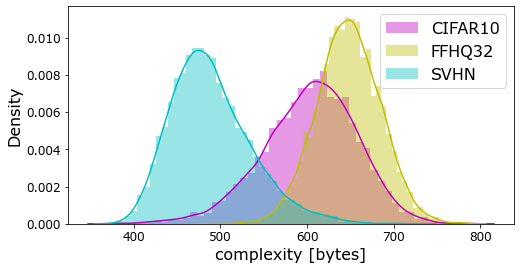

In [109]:
plot_complexity_distribution(COLOR_DATASETS, hist=True)
plt.savefig("fig/complexity_dist_color.pdf", bbox_inches='tight')

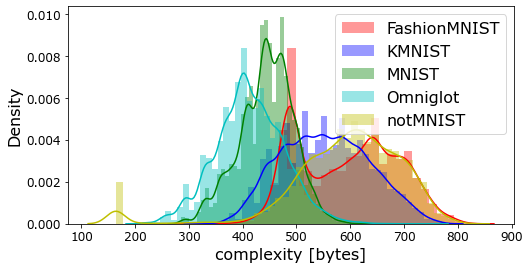

In [110]:
plot_complexity_distribution(['FashionMNISTBinarized val', 'KMNISTBinarized val',
       'MNISTBinarized val','Omniglot28x28InvertedBinarized val', 'notMNISTBinarized val'], hist=True)

plt.savefig("fig/complexity_dist_bin.pdf", bbox_inches='tight')

# Resampling

In [140]:
name_map = {
    
                   "fmnist_pow_very_lo": "very low", 
                   "fmnist_pow_lo": "low", 
                   "fmnist": "FashionMNIST (original)",
                   "fmnist_pow_hi": "high",
                   "fmnist_pow_very_hi": "very high",
    
    
                   "cifar_pow_very_lo": "very low", 
                   "cifar_pow_lo": "low", 
                   "cifar": "CIFAR10 (original)",
                   "cifar_pow_hi": "high",
                   "cifar_pow_very_hi": "very high"
}

In [151]:
def plot_resampled(reference_dataset, score_keys, score_tuple=(0, "ELBO"),
                   legend_each=False, axes=None, plot_dist=False):
    colors = "rgbcmyk"
    correlations_df = []
    
    ncols = len(score_keys)
    if plot_dist:
        nrows = 2
    else:
        nrows = 1
    k, score_name = score_tuple
    
    j = 0
    if axes is None:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row',
                                           figsize=(5 * ncols, 5 * nrows), 
                                           facecolor="w")

    reference_dataset = reference_dataset.split()[0]
    
    for i, score_key in enumerate(score_keys):
        if plot_dist:
            ax = get_ax(1, i, axes, ncols, nrows)
            ax.grid(which="major")
            ax.grid(which="minor", linestyle='--', alpha=0.2)
            plt.xlabel("complexity [bytes]")
            
            try:
                c = np.array(complexities[f'{reference_dataset} train'])
                run_id = dist_runs[score_key]
                path = download_file(run_id, f"inds_1.npy", force_redownload=False)
                inds = np.load(path)
                sns.kdeplot(c[inds], ax=ax)
                
                plt.ylabel("Density (training)")
                plt.yticks([])
            except Exception as e:
                print(e)
        
        data = score_data[score_key]
        
        datasets = list(sorted(data[reference_dataset].keys()))
        run_ids = list(sorted(data[reference_dataset][datasets[0]][0].keys()))
        if len(run_ids) > 1:
            print("multiple runs", reference_dataset, run_ids)    
        run_id = run_ids[0]
        all_values = []
        
        ax = get_ax(0, i, axes, ncols, nrows)

        plt.title(name_map[score_key])
        if i == 0:
            plt.ylabel(rename_stat(f"{k} {score_name}"))

        for l, dataset in enumerate(datasets):
            if "train" in dataset:
                continue
                
            if legend_each:
                label = f"{dataset.split()[0]} (r={r[0]:.3f}, p={r[1]:.5f})"
            elif i == 0 and j == 0:
                label = f"{dataset.split()[0]}"
            elif dataset.split()[0] == reference_dataset:
                label = f"{dataset.split()[0]}"
            else:
                label = None

            if label and dataset.split()[0] == reference_dataset:
                label += " (in)"
            scores = data[reference_dataset][dataset][k][run_id][score_name]
            c = colors[l]

            comps = complexities[dataset]
            values = scores
            if len(comps) != len(values):
                print(f"WARNING: {len(comps)} != {len(values)} (comp vs scores) in {dataset} ({score_key})")
                comps = comps[:10000]
                values = values[:10000]
            all_values.append(values)
        
            z, r = plot_single(comps, values, c=c, label="", plot_corr=True, plot_pval=True)
            plt.legend(prop={'size': FONTSIZE})

            correlations_df.append({
                "reference_dataset": reference_dataset,
                "dataset": dataset,
                "k": k,
                "run_id": run_id,
                "run": score_key,
                "score_name": score_name,
                "r": r[0],
                "p": r[1]
            })
            
        ax.grid(which="major")
        ax.grid(which="minor", linestyle='--', alpha=0.2)
    
    # set y range
    all_values = np.concatenate(all_values)
    y_max = np.percentile(all_values, 99.5)
    y_min = np.percentile(all_values, 0.5)
    rnge = y_max - y_min
    for i, score_key in enumerate(score_keys):
        ax = get_ax(0, i, axes, ncols, nrows)
        plt.ylim((y_min - 0.4 * rnge, y_max + 0.1 * rnge))
            
    plt.subplots_adjust(hspace=.0,wspace=.0)
    return pd.DataFrame(correlations_df)
            


In [152]:
modify_font(fontsize=22, ticksize=16, titlesize=22)

run:  FashionMNISTBinarized_resampled_pow_very_lo-272
run:  FashionMNISTBinarized_test_resampled_pow_lo-257
run:  FashionMNISTBinarized_test_-253
run:  FashionMNISTBinarized_test_resampled_pow_hi-255
run:  FashionMNISTBinarized_resampled_pow_very_hi-270


,reference_dataset,dataset,k,run_id,run,score_name,r,p
0,FashionMNISTBinarized,FashionMNISTBinarized val,0,105ch1fj,fmnist_pow_very_lo,ELBO,-0.849437,0.0
1,FashionMNISTBinarized,FashionMNISTBinarized val,0,2i3lx19p,fmnist_pow_lo,ELBO,-0.847728,0.0
2,FashionMNISTBinarized,FashionMNISTBinarized val,0,29iu8ste,fmnist,ELBO,-0.840239,0.0
3,FashionMNISTBinarized,FashionMNISTBinarized val,0,1y6myw1d,fmnist_pow_hi,ELBO,-0.712966,0.0
4,FashionMNISTBinarized,FashionMNISTBinarized val,0,17l8jzvj,fmnist_pow_very_hi,ELBO,-0.685932,0.0


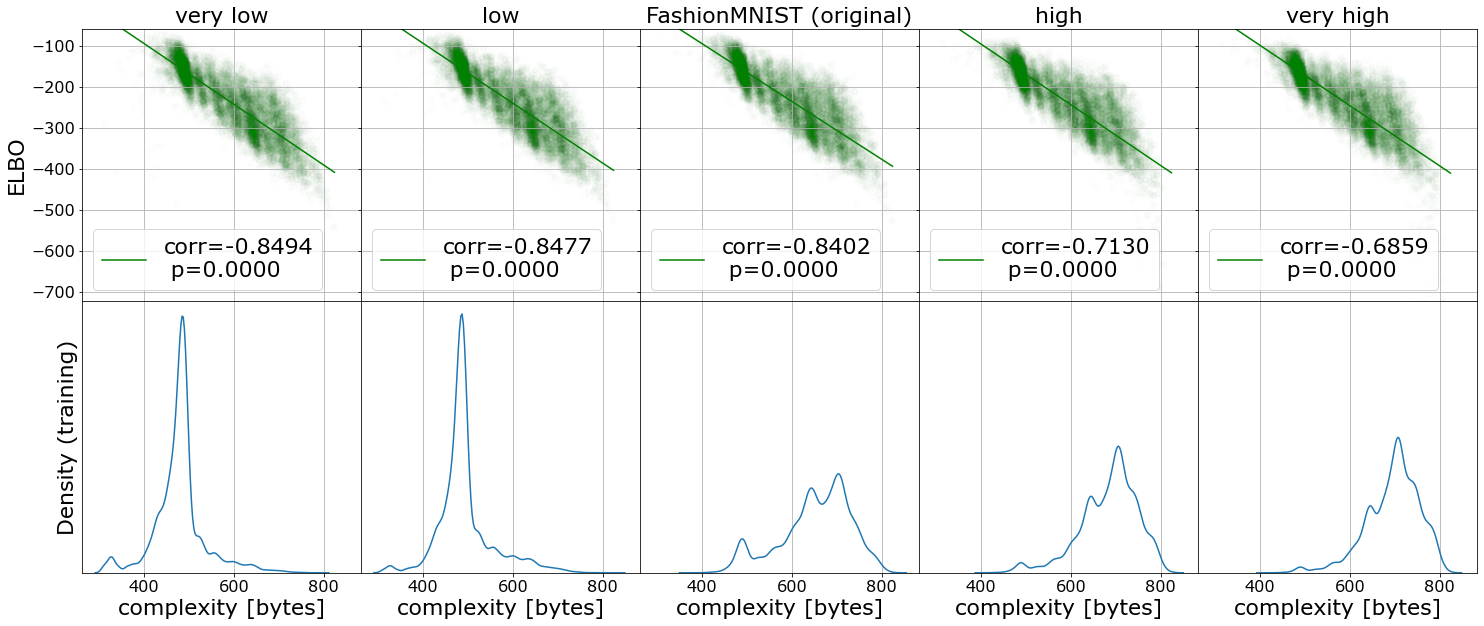

In [157]:
df = plot_resampled('FashionMNISTBinarized', 
               [
                   "fmnist_pow_very_lo", 
                   "fmnist_pow_lo", 
                   "fmnist",
                   "fmnist_pow_hi",
                   "fmnist_pow_very_hi"
               ], 
              score_tuple=(0, "ELBO"), plot_dist=True)
plt.savefig("fig/resampled_fmnist.png", bbox_inches='tight')
plt.savefig("fig/resampled_fmnist.pdf", bbox_inches='tight')
df

run:  CIFAR10Dequantized_resampled_pow_very_lo_nats_05-273
run:  CIFAR10Dequantized_test_resampled_pow_lo_nats_05-260
run:  CIFAR10Dequantized_test__nats_05-254
run:  CIFAR10Dequantized_test_resampled_pow_hi_nats_05-258
run:  CIFAR10Dequantized_resampled_pow_very_hi_nats_05-271


,reference_dataset,dataset,k,run_id,run,score_name,r,p
0,CIFAR10Dequantized,CIFAR10Dequantized val,0,b3968ibh,cifar_pow_very_lo,ELBO,-0.539392,0.0
1,CIFAR10Dequantized,CIFAR10Dequantized val,0,1la9248j,cifar_pow_lo,ELBO,-0.672030,0.0
2,CIFAR10Dequantized,CIFAR10Dequantized val,0,1vf6gfnd,cifar,ELBO,-0.700691,0.0
3,CIFAR10Dequantized,CIFAR10Dequantized val,0,22snv7ne,cifar_pow_hi,ELBO,-0.695203,0.0
4,CIFAR10Dequantized,CIFAR10Dequantized val,0,18c3q1mg,cifar_pow_very_hi,ELBO,-0.693455,0.0


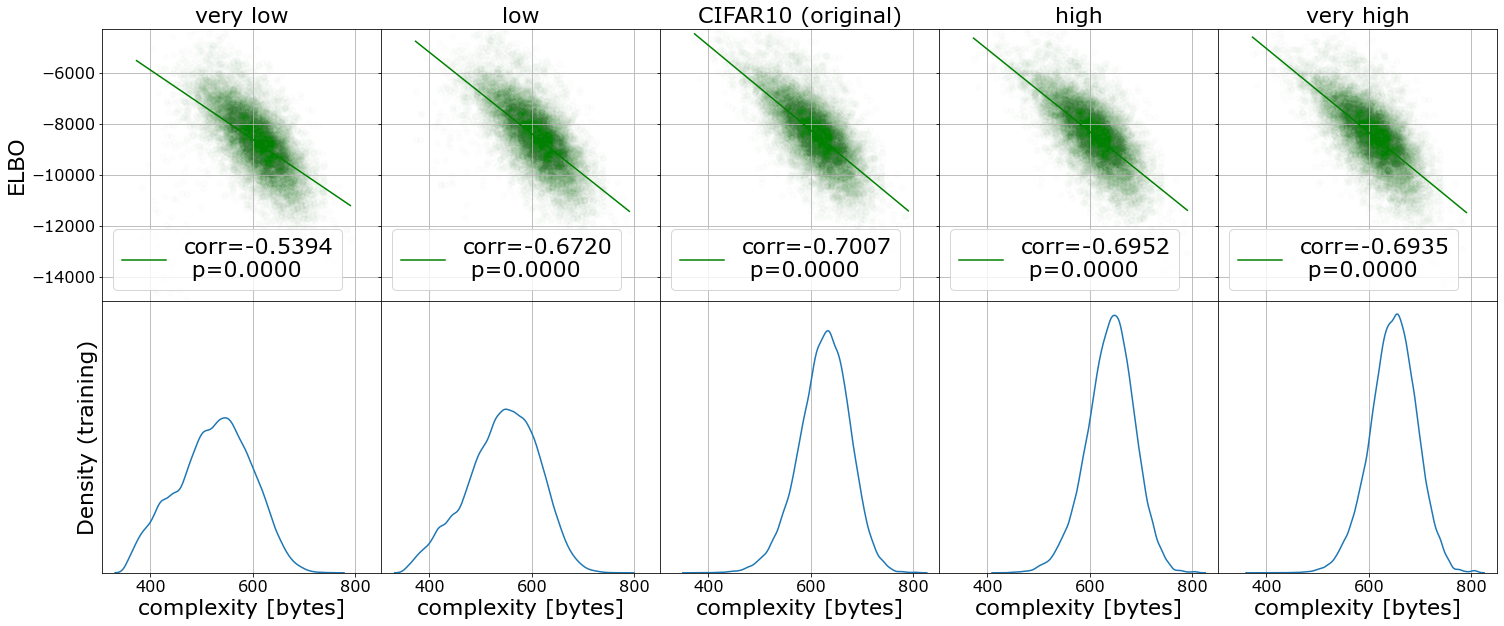

In [156]:
df = plot_resampled('CIFAR10Dequantized', 
               [
                   "cifar_pow_very_lo", 
                   "cifar_pow_lo", 
                   "cifar",
                   "cifar_pow_hi",
                   "cifar_pow_very_hi"
               ], 
              score_tuple=(0, "ELBO"), plot_dist=True)
plt.savefig("fig/resampled_cifar.png", bbox_inches='tight')
plt.savefig("fig/resampled_cifar.pdf", bbox_inches='tight')